## Baseline

## Data Prep

In [1]:
#imports
import torch
import torchvision #PyTorch models, datasets, transofmrations etc
import torchvision.transforms as transforms

In [2]:
#Download Train And Test Data
train_data = torchvision.datasets.MNIST(root = "./MNIST_train", download = True, train = True, transform = transforms.ToTensor())
test_data = torchvision.datasets.MNIST(root = "./MNIST_test", download = True, train = False, transform = transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST_train/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_train/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST_train/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_train/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST_train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_train/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST_train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_train/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST_test/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_test/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST_test/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_test/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST_test/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_test/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST_test/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_test/MNIST/raw



In [5]:
#Startified Split Of Train Data Into Training and Validataion Sets

#The following thread was referred to for writing the code in this cell
#https://discuss.pytorch.org/t/how-to-do-a-stratified-split/62290

from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import SubsetRandomSampler, DataLoader

#Get The Train Data Targets Array
labels = train_data.targets
#Get The Splitting Indices - use 80-20 split again.
train_ind, val_ind = train_test_split(np.arange(len(labels)), test_size = 0.2, shuffle = True, stratify = labels)

tr_sampler = SubsetRandomSampler(train_ind)
val_sampler = SubsetRandomSampler(val_ind)

#Define Batch Size For Mini Batch Gradient Descent
# batch_size = 128
batch_size = 64

#Create Data Loaders For Training And Validation Set
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=tr_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=val_sampler)


In [6]:
#Create Data Loaders For Test Set
test_loader = DataLoader(test_data, batch_size=batch_size)

## Modelling

In [7]:
#The following repository was referred to for writing the code in the below cells
# https://github.com/satyajitghana/PadhAI-Course/blob/master/colab-notebooks/16_PyTorchCNN.ipynb
# https://androidkt.com/initialize-weight-bias-pytorch/
# https://wandb.ai/authors/ayusht/reports/Implementing-Dropout-in-PyTorch-With-Example--VmlldzoxNTgwOTE



In [10]:
#Define Model Architecture - Batch Norm
import torch.nn as nn

class BaselineCnn(nn.Module):
  def __init__(self):
    super(BaselineCnn, self).__init__()

    #Define Layers
    self.conv1 = nn.Conv2d(1,12,8)
    self.conv2 = nn.Conv2d(12,12,4)
    self.lin1 = nn.Linear(3888,30)
    self.lin2 = nn.Linear(30, 10)

    nn.init.xavier_uniform(self.conv1.weight)
    nn.init.xavier_uniform(self.conv2.weight)
    nn.init.xavier_uniform(self.lin1.weight)
    nn.init.xavier_uniform(self.lin2.weight)

    #Add Convolutional Layers
    self.cnn_layers = nn.Sequential(
        self.conv1,
        # nn.Conv2d(1,12,8),
        # nn.Conv2d(3,12,8),
        nn.ReLU(),

        nn.BatchNorm2d(12),

        self.conv2,
        # nn.Conv2d(12,12,4),
        nn.ReLU()

        ,
        nn.BatchNorm2d(12)

    )

    #Add Fully Connected Layers
    self.fc_layers = nn.Sequential(
        # nn.Linear(576,30),
        # nn.Linear(3888,30),
        self.lin1,
        nn.ReLU(),
        self.lin2
        # nn.Linear(30, 10)
        #Softmax?
    )

  

  #Define Forward Path
  def forward(self, x):
    x = self.cnn_layers(x)
    # print(x.shape)
    x = x.view(x.size(0), -1)
    # print(x.shape)
    x = self.fc_layers(x)
    # print(x.shape)

    return x



In [11]:
model = BaselineCnn()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [12]:
#Create Function To Evaluate The Trained Model when given a dataloader and a model
def evall(dl, model):  
    tot = 0
    corr = 0
    # for data in dataloader:
    for batch in dl:
        ip, op = batch
        preds = model(ip)
        #Get The Class With The Maximum Output Value
        v, pred = torch.max(preds.data, 1)
        #Increment The Number Of Samples Tested Against
        tot += op.size(0)
        #Increment The Number Of Correctly Classified Samples
        corr += (pred == op).sum().item()

    acc = 100 * corr / tot
    print('Accuracy:', acc, '%')
    return acc

## Training

In [13]:
#Define The Loss Function, Training Optimizer and The Learning Rate Scheduler

# The following sources were referred to while writing the code in the below cells
# https://discuss.pytorch.org/t/performing-mini-batch-gradient-descent-or-stochastic-gradient-descent-on-a-mini-batch/21235/5

# https://stackoverflow.com/questions/60050586/pytorch-change-the-learning-rate-based-on-number-of-epochs

import torch.optim as optim

#Define Start Leanring Rate and Momentum

start_lr = 0.05
momentum = 0.9

#Already Applies SoftMax???
loss_function = nn.CrossEntropyLoss()
opti = optim.SGD(model.parameters(), lr = start_lr, momentum=momentum)

#create the learning rate scheduler to change lr to 10% of lr every 10 epochs
lrscheduler = optim.lr_scheduler.StepLR(opti, step_size=10, gamma = 0.1)

In [14]:
#Train on GPU
dev = "cuda:0" if torch.cuda.is_available() else "cpu"
td = torch.device(dev)
print(td)

cuda:0


In [15]:
tbs = int(60000*0.8)
vbs = int(60000*0.2)
tdl = DataLoader(train_data, batch_size=tbs, sampler=tr_sampler)
vdl = torch.utils.data.DataLoader(train_data, batch_size=vbs, sampler=val_sampler)


epoch_tr_losses = []
epoch_val_losses = []
epoch_val_accs = []
epoch_tr_accs = []
max_epochs = 20

#Define Early Stopping Patience - here 2 epochs
es_patience_count = 3
es_count = 0


for epoch in range(max_epochs):

    # for ind, data in enumerate(train_loader):
    for data in train_loader:

        ip, op = data

        opti.zero_grad()

        preds = model(ip)

        loss = loss_function(preds, op)
        loss.backward()
        opti.step()
        
        # loss_arr.append(loss.item())

    lrscheduler.step()

    # print('BL')
    for td in tdl:
      tr_ip, tr_op = td
      tr_preds = model(tr_ip)
      lt = loss_function(tr_preds, tr_op)
      epoch_tr_losses.append(lt.item())
    # print('PL')

    for vd in vdl:
      val_ip, val_op = vd
      val_preds = model(val_ip)
      lt = loss_function(val_preds, val_op)
      epoch_val_losses.append(lt.item())
        
    if epoch % 10 == 0:
      print(f"Epoch Number: {epoch} lr: {opti.param_groups[0]['lr']}")

    val_acc = evall(valid_loader, model)
    tr_acc = evall(train_loader, model)

    epoch_val_accs.append(val_acc)
    epoch_tr_accs.append(tr_acc)

    #Early Stopping based on vaidation acc

    if epoch == 0:
      best_loss = epoch_val_losses[0]

    print(epoch_val_losses[epoch] , best_loss)

    if epoch_val_losses[epoch] < best_loss:
      best_loss = epoch_val_losses[epoch]
      torch.save(model, 'best_model.pth')
    else:
      es_count += 1

    print(f"Epoch Number: {epoch}/{max_epochs}, Validation Accuracy: {val_acc}, Train Accuracy: {tr_acc}, Training Loss: {epoch_tr_losses[epoch]}, Validation Loss: {epoch_val_losses[epoch]}, Learning Rate: {opti.param_groups[0]['lr']}")

    # "Implement Early Stopping"
    if es_count > es_patience_count:
      print(f'Early Stopping Implemented at epoch {epoch}')
      break

Epoch Number: 0 lr: 0.05
Accuracy: 97.025 %
Accuracy: 97.5625 %
0.10044188797473907 0.10044188797473907
Epoch Number: 0/20, Validation Accuracy: 97.025, Train Accuracy: 97.5625, Training Loss: 0.07938473671674728, Validation Loss: 0.10044188797473907, Learning Rate: 0.05
Accuracy: 98.225 %
Accuracy: 98.48958333333333 %
0.0627012625336647 0.10044188797473907
Epoch Number: 1/20, Validation Accuracy: 98.225, Train Accuracy: 98.48958333333333, Training Loss: 0.05079161003232002, Validation Loss: 0.0627012625336647, Learning Rate: 0.05
Accuracy: 98.325 %
Accuracy: 99.01458333333333 %
0.05700235068798065 0.0627012625336647
Epoch Number: 2/20, Validation Accuracy: 98.325, Train Accuracy: 99.01458333333333, Training Loss: 0.03221556544303894, Validation Loss: 0.05700235068798065, Learning Rate: 0.05
Accuracy: 98.16666666666667 %
Accuracy: 98.96458333333334 %
0.06687203794717789 0.05700235068798065
Epoch Number: 3/20, Validation Accuracy: 98.16666666666667, Train Accuracy: 98.96458333333334, Tr

## Results and Discussion

- We can see from the learning curves that batch normalization helps the model train faster and improves the results as well with the model achieving testing, training and validation accuracies around 98% much faster than without batch normalization. We implement early stopping with a patience of 3 epochs, and as the model converges very qucikly training stops after the 5th epoch itself. But in this case we can also notice that the model seems to have very slightly overfitted when the learning curve is looked at (less than 1% difference in train and validation accuracies). 

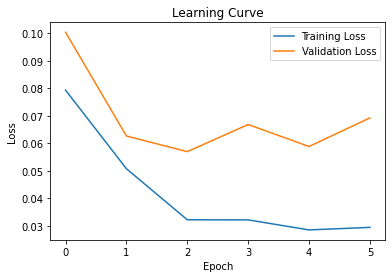

In [16]:
#Plot Learning Curves
import matplotlib.pyplot as plt
plt.plot(epoch_tr_losses, label = 'Training Loss')
plt.plot(epoch_val_losses, label = 'Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
#Test Accuracy
evall(test_loader, model)

Accuracy: 98.49 %


98.49

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def cal_confusion_matrix(dl, model):
    preds = torch.empty((0))
    labels = torch.empty((0))
    for batch in dl:
        ip, op = batch
        pred = model(ip)
        #Get The Class With The Maximum Output Value
        v, pred = torch.max(pred.data, 1)
        #Increment The Number Of Samples Tested Against
        preds = torch.cat((preds, pred))
        labels = torch.cat((labels, op))
    
    # print(preds.shape, labels.shape)
    ConfusionMatrixDisplay.from_predictions(labels, preds)
    plt.show()

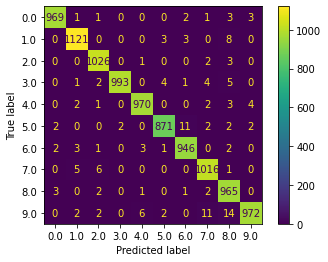

In [20]:
cal_confusion_matrix(test_loader, model)


# References

Therefore the following sources were referred to for this assignment (Mentioning all the sources at one place again):

- https://pytorch.org/docs/stable/index.html

- https://scikit-learn.org/0.21/documentation.html

- https://discuss.pytorch.org/t/how-to-do-a-stratified-split/62290

- https://github.com/satyajitghana/PadhAI-Course/blob/master/colab-notebooks/16_PyTorchCNN.ipynb

- https://androidkt.com/initialize-weight-bias-pytorch/

- https://wandb.ai/authors/ayusht/reports/Implementing-Dropout-in-PyTorch-With-Example--VmlldzoxNTgwOTE

- https://discuss.pytorch.org/t/performing-mini-batch-gradient-descent-or-stochastic-gradient-descent-on-a-mini-batch/21235/5

- https://stackoverflow.com/questions/60050586/pytorch-change-the-learning-rate-based-on-number-of-epochs



